※開発環境はGoogle Colabです。

**0.概要**

東証プライム市場に上場されている全銘柄のなかから、気になる銘柄のティッカーを入力すれば、過去２～４年分の毎日のPBRの推移を計算して表示する関数を作成する。



*   PBR =　時価総額（株価 * 発行数） / 株主資本



求めたい企業の株価・発行数・株主資本のデータを取得して、上の式に当てはめることでそれが達成できる。







**1.必要なライブラリのインポート等（環境設定）**

In [1]:
#Google認証
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

In [3]:
# yahooqueryから金融指標を取得できる
!pip install yahooquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.8 MB/s eta 0:00:00


In [4]:
# データフレームをGoogleスプレッドシートに書き出す
!pip install gspread_dataframe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from yahooquery import Ticker

import pandas_datareader.data as web
import datetime as dt

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**2.関数生成**

東証プライム市場に上場されている銘柄のティッカー(例:7912)を入力すると、
2～４年分のPBRの推移・株価の推移をグラフで表示＆PBRの推移のデータフレームを取得できる関数を生成。

※２～４年とバラつきがあるのは、銘柄によって、４年分のデータがある場合と２年分のデータしかない場合があるため。

※PBR計算のための金融指標は、yahooqueryのAPIを使用して取得

In [6]:
def PBR(ticker):
    # ====まずは東証プライム全銘柄のBSデータをデータフレームとして取得====

    #spreadsheetを開く（BSデータ）
    url = "https://docs.google.com/spreadsheets/d/1SxMC3GUKHCHCPUX4NTuhU6rDeVrmR3aIMqA-hNVJbIc/edit#gid=1407125800"
    ss = gc.open_by_url(url)

    sheet3 = ss.get_worksheet(2) #3枚目のシート取得
    all_values_bs = sheet3.get_all_values() # シートの全データを取得
    df_bs = pd.DataFrame.from_records(all_values_bs) # pandasで読み込み

    # 1行目が列名になっているので、列名に変換して1行目は削除
    new_columns = df_bs.iloc[0, :] # 1行目の値を取得する
    df_bs = df_bs.rename(columns=new_columns) # 列の名前を変更する
    df_bs = df_bs.drop(0) #1行目は削除
    # 必要な列のみ抽出
    desired_columns = ["symbol", "asOfDate", "StockholdersEquity", "ShareIssued"]
    df_bs = df_bs[desired_columns]
    # 日付をobjectからdatetimeに変換
    df_bs["asOfDate"] = pd.to_datetime(df_bs["asOfDate"]) 
    # 欠損値2点のある行を削除
    df_bs = df_bs.drop(df_bs[(df_bs["symbol"] == "3053.T") & (df_bs["asOfDate"].dt.year == 2019)].index)
    df_bs = df_bs.drop(df_bs[(df_bs["symbol"] == "7944.T") & (df_bs["asOfDate"].dt.year == 2019)].index)
    # StockholdersEquity(株主資本)とShareIssued(発行済み株式数)をstrからfloatに変更
    df_bs["StockholdersEquity"] = df_bs["StockholdersEquity"].astype(float)
    df_bs["ShareIssued"] = df_bs["ShareIssued"].astype(float)


    # ====ここから先は、求めたいtickerについての情報処理====

    # df_bsからtickerの情報のみを抽出
    ticker_t = str(ticker) + '.T'
    df_bs_ticker = df_bs[df_bs["symbol"] == ticker_t] # 該当銘柄の行をすべて抽出
    df_bs_ticker = df_bs_ticker.set_index('asOfDate') # 日付をindexに変更

    # tickerの株価取得
    start = df_bs_ticker.index[0]
    end = df_bs_ticker.index[-1] + pd.offsets.DateOffset(years=1) - pd.offsets.DateOffset(days=1) 

    price = Ticker(ticker_t).history(start=start, end=end).droplevel(level='symbol') # 株価取得
    price.index = pd.to_datetime(price.index) # indexをobjectからdatetimeに変換
    price = price.loc[:, "close"] # 終値だけ抽出

    # PBRを計算するための3要素を用意
    # PBR =　時価総額（株価price * 発行数ShareIssued） / 株主資本StockholdersEquity

    # 株主資本=se
    se_0 = df_bs_ticker.loc[df_bs_ticker.index[0], 'StockholdersEquity']
    if len(df_bs_ticker.index) > 1:
        se_1 = df_bs_ticker.loc[df_bs_ticker.index[1], 'StockholdersEquity']
    if len(df_bs_ticker.index) > 2:
        se_2 = df_bs_ticker.loc[df_bs_ticker.index[2], 'StockholdersEquity']
    if len(df_bs_ticker.index) > 3:
        se_3 = df_bs_ticker.loc[df_bs_ticker.index[3], 'StockholdersEquity']
    if len(df_bs_ticker.index) > 4:
        se_4 = df_bs_ticker.loc[df_bs_ticker.index[4], 'StockholdersEquity']

    # 株式発行数=si
    si_0 = df_bs_ticker.loc[df_bs_ticker.index[0], 'ShareIssued']
    if len(df_bs_ticker.index) > 1:
        si_1 = df_bs_ticker.loc[df_bs_ticker.index[1], 'ShareIssued']
    if len(df_bs_ticker.index) > 2:
        si_2 = df_bs_ticker.loc[df_bs_ticker.index[2], 'ShareIssued']
    if len(df_bs_ticker.index) > 3:
        si_3 = df_bs_ticker.loc[df_bs_ticker.index[3], 'ShareIssued']
    if len(df_bs_ticker.index) > 4:
        si_4 = df_bs_ticker.loc[df_bs_ticker.index[4], 'ShareIssued']

    # 株価=price
    price_0 = price[df_bs_ticker.index[0]:df_bs_ticker.index[1] - pd.offsets.DateOffset(days=1)]

    if len(df_bs_ticker.index) > 2:
        price_1 = price[df_bs_ticker.index[1]:df_bs_ticker.index[2] - pd.offsets.DateOffset(days=1)]
    elif len(df_bs_ticker.index) == 2:
        price_1 = price[df_bs_ticker.index[1]:df_bs_ticker.index[1] + pd.offsets.DateOffset(years=1)- pd.offsets.DateOffset(days=1)]
    else:
        price_1 = None

    if len(df_bs_ticker.index) > 3:
        price_2 = price[df_bs_ticker.index[2]:df_bs_ticker.index[3] - pd.offsets.DateOffset(days=1)]
    elif len(df_bs_ticker.index) == 3:
        price_2 = price[df_bs_ticker.index[2]:df_bs_ticker.index[2] + pd.offsets.DateOffset(years=1)- pd.offsets.DateOffset(days=1)]
    else:
        price_2 = None
        
    if len(df_bs_ticker.index) > 4:
        price_3 = price[df_bs_ticker.index[3]:df_bs_ticker.index[4] - pd.offsets.DateOffset(days=1)]
    elif len(df_bs_ticker.index) == 4:
        price_3 = price[df_bs_ticker.index[3]:df_bs_ticker.index[3] + pd.offsets.DateOffset(years=1)- pd.offsets.DateOffset(days=1)]
    else:
        price_3 = None

    prices = pd.concat([price_0, price_1, price_2, price_3]) 

    # PBRを計算
    pbr0 = price_0 * si_0 / se_0
    pbr1 = price_1 * si_1 / se_1
    if 'price_2' in locals() and 'si_2' in locals() and 'se_2' in locals():
        pbr2 = price_2 * si_2 / se_2
    else:
        pbr2 = None
    if 'price_3' in locals() and 'si_3' in locals() and 'se_3' in locals():
        pbr3 = price_3 * si_3 / se_3
    else:
        pbr3 = None

    # 求めた各年度のPBRを結合
    pbr_connect = pd.concat([pbr0, pbr1, pbr2, pbr3])

    # ====ここから先、グラフ化====

    # グラフ1: PBRの表示
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(pbr_connect.index, pbr_connect.values, color='blue', label='PBR<1.0')
    ax1.plot(pbr_connect[pbr_connect >= 1.0].index,
            pbr_connect[pbr_connect >= 1.0].values, color='red', linewidth=2.0, label='PBR>=1.0')
    ax1.set_title("PBR of " + str(ticker))
    ax1.set_xlabel("Date")
    ax1.set_ylabel("PBR")
    ax1.legend()

    # グラフ2: 株価の表示
    fig, ax2 = plt.subplots(figsize=(12, 6))
    ax2.plot(pbr_connect.index, prices, color='green', label='Stock Price')
    ax2.set_title("Stock Price of " + str(ticker))
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Price")
    ax2.legend()

    # x軸の範囲を共通に設定
    start_date = pbr_connect.index[0] - pd.offsets.DateOffset(days=20)
    end_date = pbr_connect.index[-1] + pd.offsets.DateOffset(days=20)
    ax1.set_xlim(start_date, end_date)
    ax2.set_xlim(start_date, end_date)

    # グラフの表示
    plt.show()

    return pbr_connect

**3.作成した関数を実際に使用**

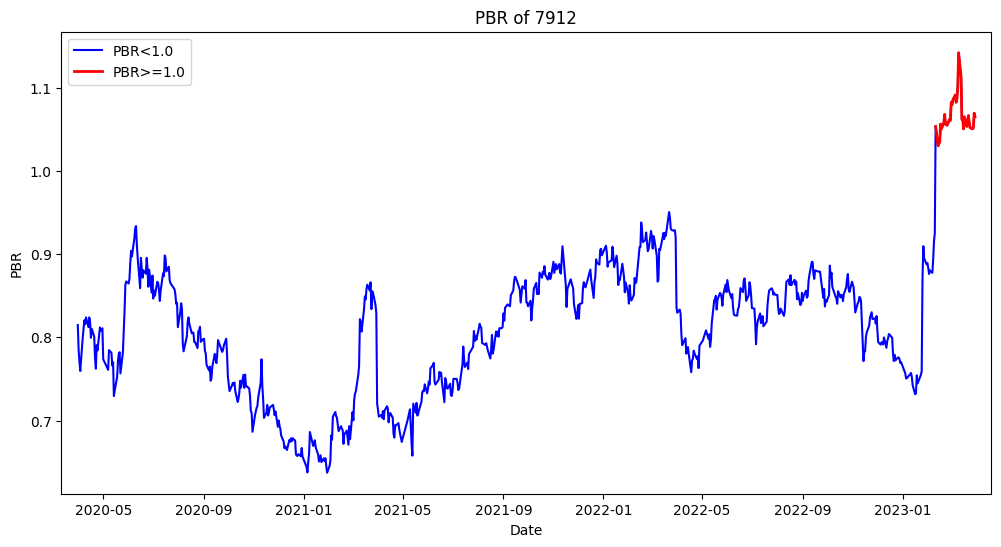

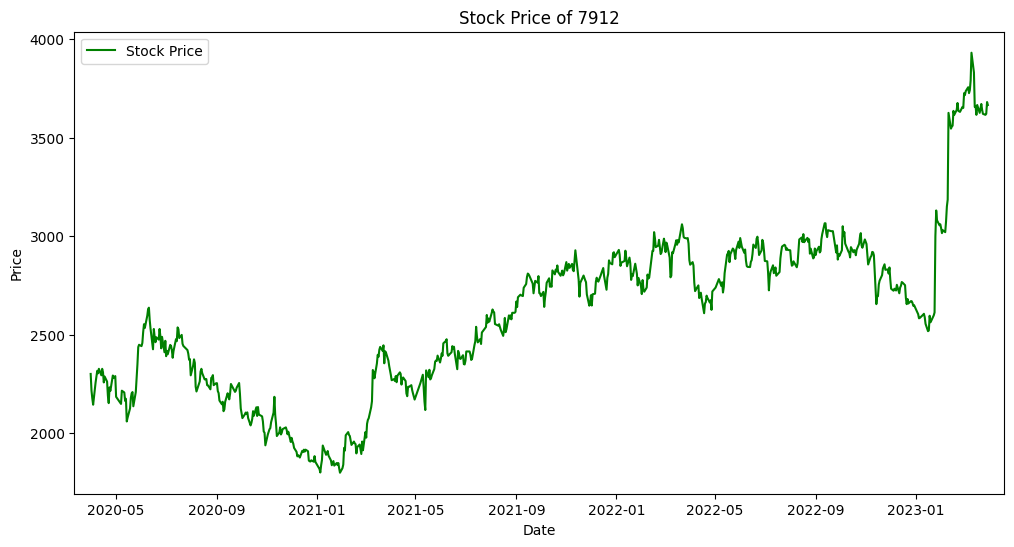

date
2020-03-31    0.814691
2020-04-01    0.784596
2020-04-02    0.770434
2020-04-03    0.759458
2020-04-06    0.799467
                ...   
2023-03-24    1.051792
2023-03-27    1.050340
2023-03-28    1.051792
2023-03-29    1.069225
2023-03-30    1.064867
Name: close, Length: 733, dtype: float64

In [7]:
# 試しに大日本印刷のティッカーを入力してみる
PBR(7912)